**1. Input libraries**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import matplotlib.pylab as plt
from IPython.core.pylabtools import figsize
import itertools
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.optimizers import Adagrad

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical

from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import SeparableConv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout, SpatialDropout2D
from keras.layers.core import Dense
from keras import backend as K
%matplotlib inline

/kaggle/input/lymphoma-subtype-classification-fl-vs-cll/Y.npy
/kaggle/input/lymphoma-subtype-classification-fl-vs-cll/X.npy


**2. Load the data**

In [2]:
#for pictues
# load images of shape (5547, 50, 50, 3)
X = np.load('/kaggle/input/lymphoma-subtype-classification-fl-vs-cll/X.npy')  

# load labels of shape (5547,1); (0 = no cancer, 1 = cancer)
Y = np.load('/kaggle/input/lymphoma-subtype-classification-fl-vs-cll/Y.npy')   

# shuffle data
perm_array = np.arange(len(X))
np.random.shuffle(perm_array)
X = X[perm_array]
Y = Y[perm_array]

print('X-images.shape =', X.shape, ', Y-images.shape =', Y.shape)

X-images.shape = (5547, 50, 50, 3) , Y-images.shape = (5547,)


In [3]:
#labels are equally distributed
print('There are', len(X[Y==0]), 'negative examples. There are', len(X[Y==1]), 'positive examples')

There are 2759 negative examples. There are 2788 positive examples


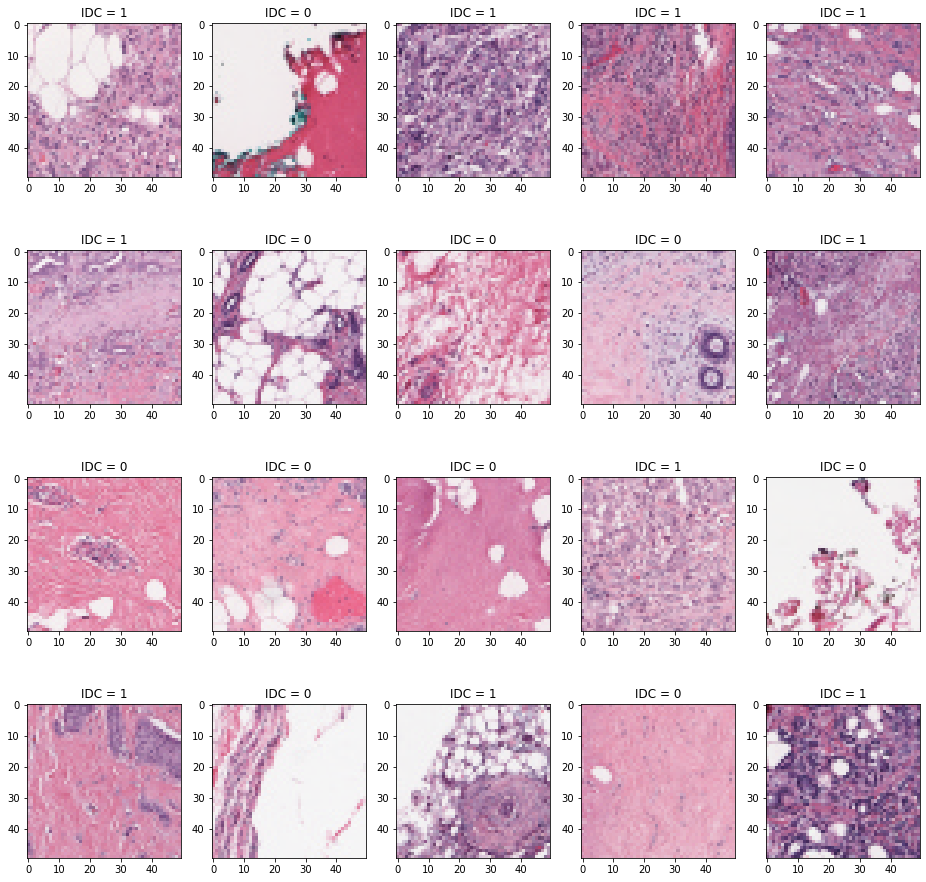

In [4]:
plt.figure(figsize=(16,16))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.title('IDC = %d'%Y[i])
    plt.imshow(X[i])

In [5]:
#normalization
X=X/255.0

#making data in 1D for ML algorithms, we take the length of X as first parameter and multiply the rest
X_reshaped = X.reshape(X.shape[0], X.shape[1]*X.shape[2]*X.shape[3])
print(X_reshaped.shape)

#splitting data
X_train, X_test, Y_train, Y_test = train_test_split(X_reshaped, Y, test_size=0.2)
print('Train size:', X_train.shape,'Test size:', X_test.shape)

(5547, 7500)
Train size: (4437, 7500) Test size: (1110, 7500)


In [6]:
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X_train, Y_train)
    
    # Make predictions and evalute
    model_pred = model.predict(X_test)
    model_accuracy = accuracy_score(Y_test, model_pred)
    
    # Return the performance metric
    return model_accuracy

In [7]:
#Decision Tree Classifier
DTR = DecisionTreeClassifier(random_state=42)
DTR_accuracy = fit_and_evaluate(DTR)
print('DTR accuracy:', DTR_accuracy)

#Random Forest Classifier
RFC = RandomForestClassifier(random_state=42)
RFC_accuracy = fit_and_evaluate(RFC)
print('RFC accuracy:', RFC_accuracy)

#KNN
KNN = KNeighborsClassifier(10)
KNN_accuracy = fit_and_evaluate(KNN)
print('KNN accuracy:', KNN_accuracy)

#XGBoost Classifier
XGB = XGBClassifier(random_state=42)
XGB_accuracy = fit_and_evaluate(XGB)
print('XGB accuracy:',XGB_accuracy)

DTR accuracy: 0.6855855855855856
RFC accuracy: 0.7711711711711712
KNN accuracy: 0.7


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:26:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB accuracy: 0.7855855855855856


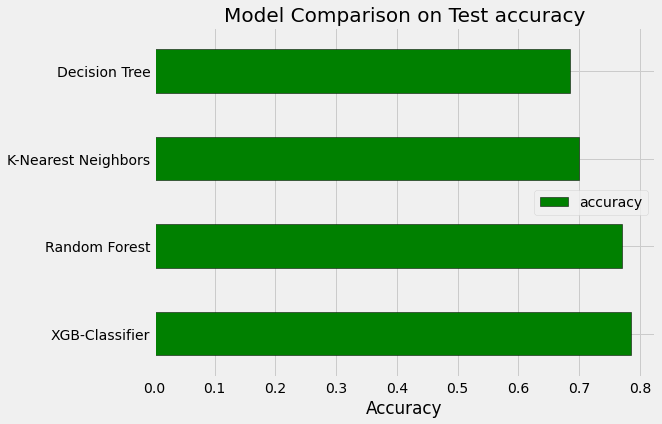

In [8]:
plt.style.use('fivethirtyeight')
figsize(8, 6)

# Dataframe to hold the results
model_comparison = pd.DataFrame({'model': 
                    ['Decision Tree', 'Random Forest',
                    'K-Nearest Neighbors', 'XGB-Classifier'],
                    'accuracy': [DTR_accuracy, RFC_accuracy, 
                             KNN_accuracy, XGB_accuracy]})

# Horizontal bar chart of test accuracy
model_comparison.sort_values('accuracy', 
                     ascending = False).plot(x = 'model', 
                     y = 'accuracy', kind = 'barh',
                     color = 'green', edgecolor = 'black')

# Plot formatting
plt.ylabel(''); plt.yticks(size = 14); 
plt.xlabel('Accuracy'); plt.xticks(size = 14)
plt.title('Model Comparison on Test accuracy', size = 20);

In general, classical algorithms demonstrate results between 70% and 80% of accuracy. XGB-clasifier shows the best result with 78,5% (it could be different - between 77% and 79% - because we didn't use random seed in splitting the data).

In [9]:
#splitting the data in 4D into train and test sets
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size = 0.2)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

#changing y-sets to categorical
ytrain = to_categorical(ytrain,2)
ytest = to_categorical(ytest,2)

In [10]:
#stopping training if validation accuracy is higher than 79%
import tensorflow as tf
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get("val_accuracy") >= 0.790):
            print("Reached 79% accuracy so cancelling training!")
            self.model.stop_training = True
callbacks=myCallback()

In [11]:
tf.keras.backend.clear_session()
K.clear_session() #clear session to make sure there is no overtraining
tf.random.set_seed(51)
np.random.seed(51)

input_shape = (xtrain.shape[1], xtrain.shape[2], 3)
batch_size = 64
num_classes = 2
epochs = 25
channelDim=-1
INIT_LR=1e-2 #initial learning rate

model = tf.keras.Sequential()

#first layer
model.add(SeparableConv2D(32, (3,3), padding="same",input_shape=input_shape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=channelDim))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(SpatialDropout2D(0.2))

#second
model.add(SeparableConv2D(64, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=channelDim))
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(SpatialDropout2D(0.3))

#third
model.add(SeparableConv2D(128, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=channelDim))

#fourth
model.add(SeparableConv2D(256, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=channelDim))
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.1))

#fifth
model.add(SeparableConv2D(256, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=channelDim))
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.1))

#sixth
model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation("softmax"))


opt=Adagrad(lr=INIT_LR,decay=INIT_LR/epochs)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [12]:
datagen = ImageDataGenerator(
        rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,
        zoom_range=0.05,
        #shear_range=0.05,
        fill_mode='nearest'
  ) 
datagen.fit(xtrain)
history_1=model.fit(datagen.flow(xtrain,ytrain, batch_size=batch_size), 
                    epochs=epochs, 
                    validation_data = (xtest, ytest),
                    verbose = 2, 
                    steps_per_epoch=len(xtrain)/batch_size,
                    shuffle=True, #shuffle the data
                    callbacks=[myCallback()]) #to stop training after getting >79% of val_acc
score_1 = model.evaluate(xtest, ytest, verbose=0)
print(score_1)

Epoch 1/25
69/69 - 22s - loss: 0.8630 - accuracy: 0.6728 - val_loss: 0.7235 - val_accuracy: 0.5135
Epoch 2/25
69/69 - 19s - loss: 0.6641 - accuracy: 0.7052 - val_loss: 0.7345 - val_accuracy: 0.5135
Epoch 3/25
69/69 - 19s - loss: 0.6177 - accuracy: 0.7144 - val_loss: 0.7070 - val_accuracy: 0.5135
Epoch 4/25
69/69 - 19s - loss: 0.5930 - accuracy: 0.7295 - val_loss: 0.6943 - val_accuracy: 0.5135
Epoch 5/25
69/69 - 19s - loss: 0.5759 - accuracy: 0.7289 - val_loss: 0.8389 - val_accuracy: 0.4865
Epoch 6/25
69/69 - 19s - loss: 0.5616 - accuracy: 0.7329 - val_loss: 1.0234 - val_accuracy: 0.4865
Epoch 7/25
69/69 - 19s - loss: 0.5477 - accuracy: 0.7460 - val_loss: 0.9185 - val_accuracy: 0.4874
Epoch 8/25
69/69 - 20s - loss: 0.5455 - accuracy: 0.7507 - val_loss: 0.7881 - val_accuracy: 0.4721
Epoch 9/25
69/69 - 20s - loss: 0.5351 - accuracy: 0.7510 - val_loss: 0.6408 - val_accuracy: 0.5973
Epoch 10/25
69/69 - 19s - loss: 0.5412 - accuracy: 0.7449 - val_loss: 0.5700 - val_accuracy: 0.7045
Epoch 11/

In [13]:
score = model.evaluate(xtest, ytest, verbose=0)
print('\nKeras CNN #1A - accuracy:', score[1],'\n')
y_pred = model.predict(xtest) 
map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
print('\n', sklearn.metrics.classification_report(np.where(ytest > 0)[1], np.argmax(y_pred, axis=1), 
                                        target_names=list(map_characters.values())), sep='')
Y_pred_classes = np.argmax(y_pred,axis = 1) 
Y_true = np.argmax(ytest,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 


Keras CNN #1A - accuracy: 0.8045045137405396 


              precision    recall  f1-score   support

      IDC(-)       0.82      0.76      0.79       540
      IDC(+)       0.79      0.85      0.82       570

    accuracy                           0.80      1110
   macro avg       0.81      0.80      0.80      1110
weighted avg       0.81      0.80      0.80      1110



Text(0.5, 0, 'epoch')

<Figure size 576x432 with 0 Axes>

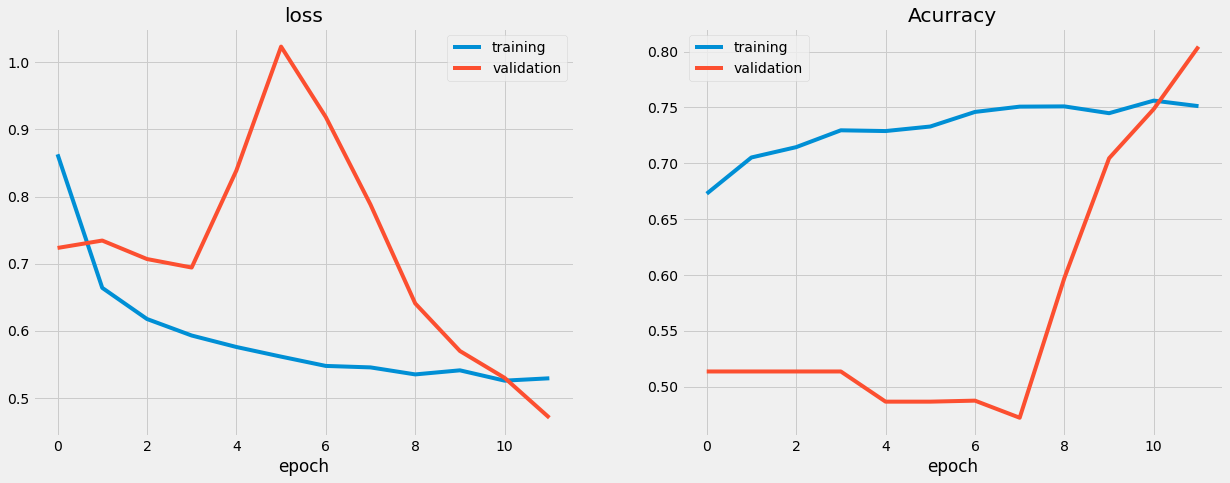

In [14]:
#plotting loss and accuracy
plt.figure()
fig,(ax1, ax2)=plt.subplots(1,2,figsize=(19,7))
ax1.plot(history_1.history['loss'])
ax1.plot(history_1.history['val_loss'])
ax1.legend(['training','validation'])
ax1.set_title('loss')
ax1.set_xlabel('epoch')

ax2.plot(history_1.history['accuracy'])
ax2.plot(history_1.history['val_accuracy'])
ax2.legend(['training','validation'])
ax2.set_title('Acurracy')
ax2.set_xlabel('epoch')

This time we saw CNN validation accuracy as 80%. These results could be different due to randomness of splitting and training the data. In general the results are between 79%-81%.